In [76]:
import numpy as np
from numpy import sin, cos, tan, atan, cosh, sinh, tanh, abs, linspace, min, max, argmin, argmax, pi, mean, exp, sqrt, zeros, ones, nan
import scipy
import matplotlib.pyplot as plt
from scipy.special import roots_legendre, eval_legendre
from numpy.polynomial import chebyshev

In [ ]:
class PerturbationCSWESolution(): pass

class PCSWE():

    def __init__(self):
        self.debug = False


        # geometry
        self.A = 0.72
        self.H = 7.12 
        self.L = 8e3

        # tunable
        self.r = 0.24
        self.h0 = 0.0025
        self.small_number = nan
        self.bc = nan
        # self.bc = self.bc_moving_boundary


        # morphodynamics
        self.p = 0.4 # porosity
        self.c_d = 0.0025
        self.lmbda = 6.8e-6
        self.d50 = 0.13e-3

        # universal constants
        self.g = 9.81
        self.sigma = 1.4e-4
        self.rho_w = 1025
        self.rho_s = 2650

        self.set_derivative_vars()
        
    def set_derivative_vars(self):
        self.epsilon = self.A / self.H
        self.eta = self.sigma * self.L / sqrt(self.g * self.H)
        self.U = self.epsilon * self.sigma * self.L
        self.kappa = self.g * self.H / (self.sigma * self.L) ** 2

        self.s = self.rho_s / self.rho_w

        self.delta = 0.04 * self.c_d**(3/2) * self.A * (self.sigma * self.L)**4 / \
                    (self.g**2 * (self.s-1)**2 * self.d50 * self.H**6 * (1-self.p))

    def generate_solution(self):
        # assume we have ran self.solve()
        t = linspace(0, 2*pi, 1000)
        x = self.y.x

        # x_mesh = x[:, np.newaxis] * ones(t.shape)[np.newaxis, :]
        # t_mesh = np.tile(t, (len(x), 1))


        dz0_xt = self.y.y[0][:, np.newaxis] * cos(t)[np.newaxis, :] + \
            self.y.y[1][:, np.newaxis] * sin(t)[np.newaxis, :]

        dz1_xt = self.y.y[4][:, np.newaxis] * ones(t.shape)[np.newaxis, :] + \
            self.y.y[5][:, np.newaxis] * cos(2*t)[np.newaxis, :] + \
            self.y.y[6][:, np.newaxis] * sin(2*t)[np.newaxis, :]


        u0_xt = self.y.y[2][:, np.newaxis] * cos(t)[np.newaxis, :] + \
            self.y.y[3][:, np.newaxis] * sin(t)[np.newaxis, :]

        u1_xt = self.y.y[7][:, np.newaxis] * ones(t.shape)[np.newaxis, :] + \
            self.y.y[8][:, np.newaxis] * cos(2*t)[np.newaxis, :] + \
            self.y.y[9][:, np.newaxis] * sin(2*t)[np.newaxis, :]
        
       
        dz_xt = dz0_xt + self.epsilon * dz1_xt
        u_xt = u0_xt + self.epsilon * u1_xt

        sol = PerturbationCSWESolution
        sol.x, sol.t, sol.dz_xt, sol.u_xt = x, t, dz_xt, u_xt
        return sol
    
    def h_fx(self, x): return x

    def h_fx_dx(self, x): return 1 * np.ones(np.array(x).shape)
    
    def h_fx_dxx(self, x): return 0
    
    def deriv_LO(self, x_x, y0_x):
        # x_x, y0_x = np.array(x_x), np.array(y0_x)
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)

        # derivatives of dzeta (using momentum equation)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)

        lhopital = True
        if lhopital:
            # derivatives of u (using continuity equation)
            with np.errstate(divide='ignore', invalid='ignore'):
                u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
                u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)

            # derivatives of u at x = 1 (using l'hopital)
            # if isinstance(x_x, np.ndarray):
            #     u0c_x_dx[-1] =  ( dz0s_x_dx[-1] - u0c_x[-1] * h_x_dxx)  / (2*h_x_dx[-1])
            #     u0s_x_dx[-1] =  (-dz0c_x_dx[-1] - u0s_x[-1] * h_x_dxx)  / (2*h_x_dx[-1])
            if abs(x_x - 1) < 1e-10:
                u0c_x_dx =  ( dz0s_x_dx - u0c_x * h_x_dxx)  / (2*h_x_dx)
                u0s_x_dx =  (-dz0c_x_dx - u0s_x * h_x_dxx)  / (2*h_x_dx)
        else:
            u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
            u0c_x_dx = np.where(abs(u0c_x) > 1e2, (-dz0s_x + u0c_x * h_x_dx) * 1e2,  u0c_x_dx)

            u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)
            u0s_x_dx = np.where(abs(u0s_x) > 1e2, ( dz0c_x + u0s_x * h_x_dx) * 1e2,  u0s_x_dx)
   
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_LO_g(self, g_g, y0_g):
        # g_g, y0_g = np.array(g_g), np.array(y0_g)
        dz0c_g, dz0s_g, u0c_g, u0s_g = y0_g
        h_g, h_g_dg, h_g_dgg = self.h_fx(1-g_g), 1-self.h_fx_dxx(1-g_g), self.h_fx_dxx(1-g_g)

        # derivatives of dzeta (using momentum equation)
        dz0c_g_dg = 1 / self.kappa * ( - self.r / (1 - h_g + self.h0) * u0c_g - u0s_g)
        dz0s_g_dg = 1 / self.kappa * ( - self.r / (1 - h_g + self.h0) * u0s_g + u0c_g)

        lhopital = True
        if lhopital:
            # derivatives of u (using continuity equation)
            with np.errstate(divide='ignore', invalid='ignore'):
                u0c_g_dg = (-dz0s_g + u0c_g * h_g_dg)  / (1 - h_g)
                u0s_g_dg = ( dz0c_g + u0s_g * h_g_dg)  / (1 - h_g)

            if abs(g_g) < 1e-10:
                u0c_g_dg =  ( dz0s_g_dg - u0c_g * h_g_dgg)  / (2*h_g_dg)
                u0s_g_dg =  (-dz0c_g_dg - u0s_g * h_g_dgg)  / (2*h_g_dg)
        else:
            u0c_g_dg = (-dz0s_g + u0c_g * h_g_dg)  / (1 - h_g)
            u0c_g_dg = np.where(abs(u0c_g) > 1e2, (-dz0s_g + u0c_g * h_g_dg) * 1e2,  u0c_g_dg)

            u0s_g_dg = ( dz0c_g + u0s_g * h_g_dg)  / (1 - h_g)
            u0s_g_dg = np.where(abs(u0s_g) > 1e2, ( dz0c_g + u0s_g * h_g_dg) * 1e2,  u0s_g_dg)
   
        return - np.array([dz0c_g_dg, dz0s_g_dg, u0c_g_dg, u0s_g_dg])
    
    
    
    def deriv_FO(self, x_x, y1_x, y0_x, y0_x_dx):
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx= self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)

        # derivatives of dzeta (using momentum equation)
        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x)
            - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x)
            - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x)
            - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa

        # derivatives of u (using continuity equation)
        u1r_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1r_x              - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x + dz0s_x * u0s_x_dx + dz0s_x_dx * u0s_x))
        u1c_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1c_x - 2 * dz1s_x - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x - dz0s_x * u0s_x_dx - dz0s_x_dx * u0s_x))
        u1s_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1s_x + 2 * dz1c_x - 1 / 2 * (dz0s_x * u0c_x_dx + dz0s_x_dx * u0c_x + dz0c_x * u0s_x_dx + dz0c_x_dx * u0s_x))

        # derivatives of first order u at x = 1 (using l'hopital)
        # u1r_x_dx[-1], u1c_x_dx[-1], u1s_x_dx[-1] = self.lhopital_FO(x_x[-1], y1_x[:, -1], y0_x[:, -1], y0_x_dx[:, -1], (dz1r_x_dx[-1], dz1c_x_dx[-1], dz1s_x_dx[-1]))
        # self.product_dxx(x_x, y0_x, y0_x_dx)

        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx])
     
       
    def deriv(self, x_x, y_x):
        y0_x, y1_x = np.split(y_x, [4], axis=0)

        y0_x_dx = self.deriv_LO(x_x, y0_x)
        y1_x_dx = self.deriv_FO(x_x, y1_x, y0_x, y0_x_dx)

        y_x_dx = np.concatenate((y0_x_dx, y1_x_dx), axis=0)

        return y_x_dx

 
    def solve_shooting(self):
        x_range = [0, 1]

        def ivp(u_l):
            print(u_l - 0.001 * np.ones((5)))
            u0c_l, u0s_l, u1r_l, u1c_l, u1s_l = u_l
            dz0c_l, dz0s_l, dz1r_l, dz1c_l, dz1s_l = 1, 0, 0, 0, 0

            y_l = dz0c_l, dz0s_l, u0c_l, u0s_l, dz1r_l, dz1c_l, dz1s_l, u1r_l, u1c_l, u1s_l

            sol = scipy.integrate.solve_ivp(
                self.deriv,
                x_range,
                y_l
            )

            # we visualize the sol
            fig, axs = plt.subplots(2, 6, figsize=(30, 10))
            labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
            for i in range(4):
                axs[0, i].set_title(labels[i])
                axs[0, i].plot(sol.t, sol.y[i])
            for i in range(6):
                axs[1, i].set_title(labels[4 + i])
                axs[1, i].plot(sol.t, sol.y[4 + i])

            plt.show()

            



            return sol
        
        def mismatch(u_l):
            sol = ivp(u_l)
            dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r = sol.y[:, -1]

            h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)

            dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
            dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)

            u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
            u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)

            return [
                dz0s_r - h_r_dx * u0c_r,
                dz0c_r + h_r_dx * u0s_r,
                h_r_dx * u1r_r - 1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r),
                h_r_dx * u1c_r - 1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) - 2 * dz1s_r,
                h_r_dx * u1s_r - 1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) + 2 * dz1c_r
            ]


          
        u_guess = 0.001 * np.ones((5))
        res = scipy.optimize.root(mismatch, u_guess)
        print(res)
        return res
    
    def solve_LO_shooting(self):
        

        def ivp(u_r, dense_output=False):

            u0c_r, u0s_r = u_r
 
            h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
            dz0s_r = h_r_dx * u0c_r
            dz0c_r = - h_r_dx * u0s_r


            # x_range = [0, 1]
            x_range = [1, 0]
            y_r = dz0c_r, dz0s_r, u0c_r, u0s_r

            sol = scipy.integrate.solve_ivp(
                lambda x,y: -self.deriv_LO(x, y),
                x_range,
                y_r,
                dense_output=dense_output,
                rtol=1e-3
            )

            # we visualize the sol
            # fig, axs = plt.subplots(2, 6, figsize=(30, 10))
            # labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
            # for i in range(4):
            #     axs[0, i].set_title(labels[i])
            #     axs[0, i].plot(sol.t, sol.y[i])
            # plt.show()
            return sol
        
        def mismatch(u_l):
            sol = ivp(u_l)

            dz0c_l, dz0s_l, u0c_l, u0s_l = sol.y[:, 0]
            return [dz0c_l - 1, dz0s_l]


        u_guess = 0.01 * np.ones((2))
        res = scipy.optimize.root(mismatch, u_guess)
        print(res)
        print(res.status)

        if res.status == 1:
            sol = ivp(res.x, dense_output=True)
            return sol

        def solve_LO_shooting(self):
        

        def ivp(u_r, dense_output=False):

            u0c_r, u0s_r = u_r
 
            h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
            dz0s_r = h_r_dx * u0c_r
            dz0c_r = - h_r_dx * u0s_r


            # x_range = [0, 1]
            x_range = [1, 0]
            y_r = dz0c_r, dz0s_r, u0c_r, u0s_r

            sol = scipy.integrate.solve_ivp(
                lambda x,y: -self.deriv_LO(x, y),
                x_range,
                y_r,
                dense_output=dense_output,
                rtol=1e-3
            )

            # we visualize the sol
            # fig, axs = plt.subplots(2, 6, figsize=(30, 10))
            # labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
            # for i in range(4):
            #     axs[0, i].set_title(labels[i])
            #     axs[0, i].plot(sol.t, sol.y[i])
            # plt.show()
            return sol
        
        def mismatch(u_l):
            sol = ivp(u_l)

            dz0c_l, dz0s_l, u0c_l, u0s_l = sol.y[:, 0]
            return [dz0c_l - 1, dz0s_l]


        u_guess = 0.01 * np.ones((2))
        res = scipy.optimize.root(mismatch, u_guess)
        print(res)
        print(res.status)

        if res.status == 1:
            sol = ivp(res.x, dense_output=True)
            return sol


    def solve_LO_g(self):
        

        def ivp(u_r, dense_output=False):

            u0c_r, u0s_r = u_r
 
            h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
            dz0s_r = h_r_dx * u0c_r
            dz0c_r = - h_r_dx * u0s_r


            # x_range = [0, 1]
            x_range = [1, 0]
            y_r = dz0c_r, dz0s_r, u0c_r, u0s_r

            sol = scipy.integrate.solve_ivp(
                lambda x,y: -self.deriv_LO(x, y),
                x_range,
                y_r,
                dense_output=dense_output,
                rtol=1e-3
            )

            # we visualize the sol
            # fig, axs = plt.subplots(2, 6, figsize=(30, 10))
            # labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
            # for i in range(4):
            #     axs[0, i].set_title(labels[i])
            #     axs[0, i].plot(sol.t, sol.y[i])
            # plt.show()
            return sol
        
        def mismatch(u_l):
            sol = ivp(u_l)

            dz0c_l, dz0s_l, u0c_l, u0s_l = sol.y[:, 0]
            return [dz0c_l - 1, dz0s_l]


        u_guess = 0.01 * np.ones((2))
        res = scipy.optimize.root(mismatch, u_guess)
        print(res)
        print(res.status)

        if res.status == 1:
            sol = ivp(res.x, dense_output=True)
            return sol

        def solve_LO_shooting(self):
        

        def ivp(u_r, dense_output=False):

            u0c_r, u0s_r = u_r
 
            h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
            dz0s_r = h_r_dx * u0c_r
            dz0c_r = - h_r_dx * u0s_r


            # x_range = [0, 1]
            x_range = [1, 0]
            y_r = dz0c_r, dz0s_r, u0c_r, u0s_r

            sol = scipy.integrate.solve_ivp(
                lambda x,y: -self.deriv_LO(x, y),
                x_range,
                y_r,
                dense_output=dense_output,
                rtol=1e-3
            )

            # we visualize the sol
            # fig, axs = plt.subplots(2, 6, figsize=(30, 10))
            # labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
            # for i in range(4):
            #     axs[0, i].set_title(labels[i])
            #     axs[0, i].plot(sol.t, sol.y[i])
            # plt.show()
            return sol
        
        def mismatch(u_l):
            sol = ivp(u_l)

            dz0c_l, dz0s_l, u0c_l, u0s_l = sol.y[:, 0]
            return [dz0c_l - 1, dz0s_l]


        u_guess = 0.01 * np.ones((2))
        res = scipy.optimize.root(mismatch, u_guess)
        print(res)
        print(res.status)

        if res.status == 1:
            sol = ivp(res.x, dense_output=True)
            return sol


    def visualize_components(self):
        # assume self.solve() has been called

        fig, axs = plt.subplots(2, 6, figsize=(30, 10))
        labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
        for i in range(4):
            axs[0, i].set_title(labels[i])
            axs[0, i].plot(self.y.x, self.y.y[i])
        for i in range(6):
            axs[1, i].set_title(labels[4 + i])
            axs[1, i].plot(self.y.x, self.y.y[4 + i])

        plt.show()


[0. 0.]
1.0
0.8472105105080887
0.991028969845971
0.9865434547689566
0.9641158793838841
0.9601287548709823
0.9551448492298551
0.9551448492298551
0.9956314839215601
0.9934472258823401
0.9825259356862404
0.9805843729847115
0.9781574196078004
0.9781574196078004
0.9978693109000516
0.9968039663500774
0.9914772436002064
0.990530270666896
0.989346554500258
0.989346554500258
0.9989599824056741
0.9984399736085111
0.9958399296226962
0.9953776995807736
0.9947999120283703
0.9947999120283703
0.9994921679040218
0.9992382518560328
0.9979686716160873
0.9977429684623192
0.9974608395201091
0.9974608395201091
0.9997519865104365
0.9996279797656548
0.9990079460417461
0.9988977178241624
0.9987599325521826
0.9987599325521826
0.9998788657814189
0.9998182986721283
0.9995154631256756
0.9994616256951951
0.9993943289070946
0.9993943289070946
0.999940833484835
0.9999112502272524
0.9997633339393397
0.9997370377103775
0.9997041674241747
0.9997041674241747
0.9999711002757138
0.9999566504135706
0.999884401102855
0.9998

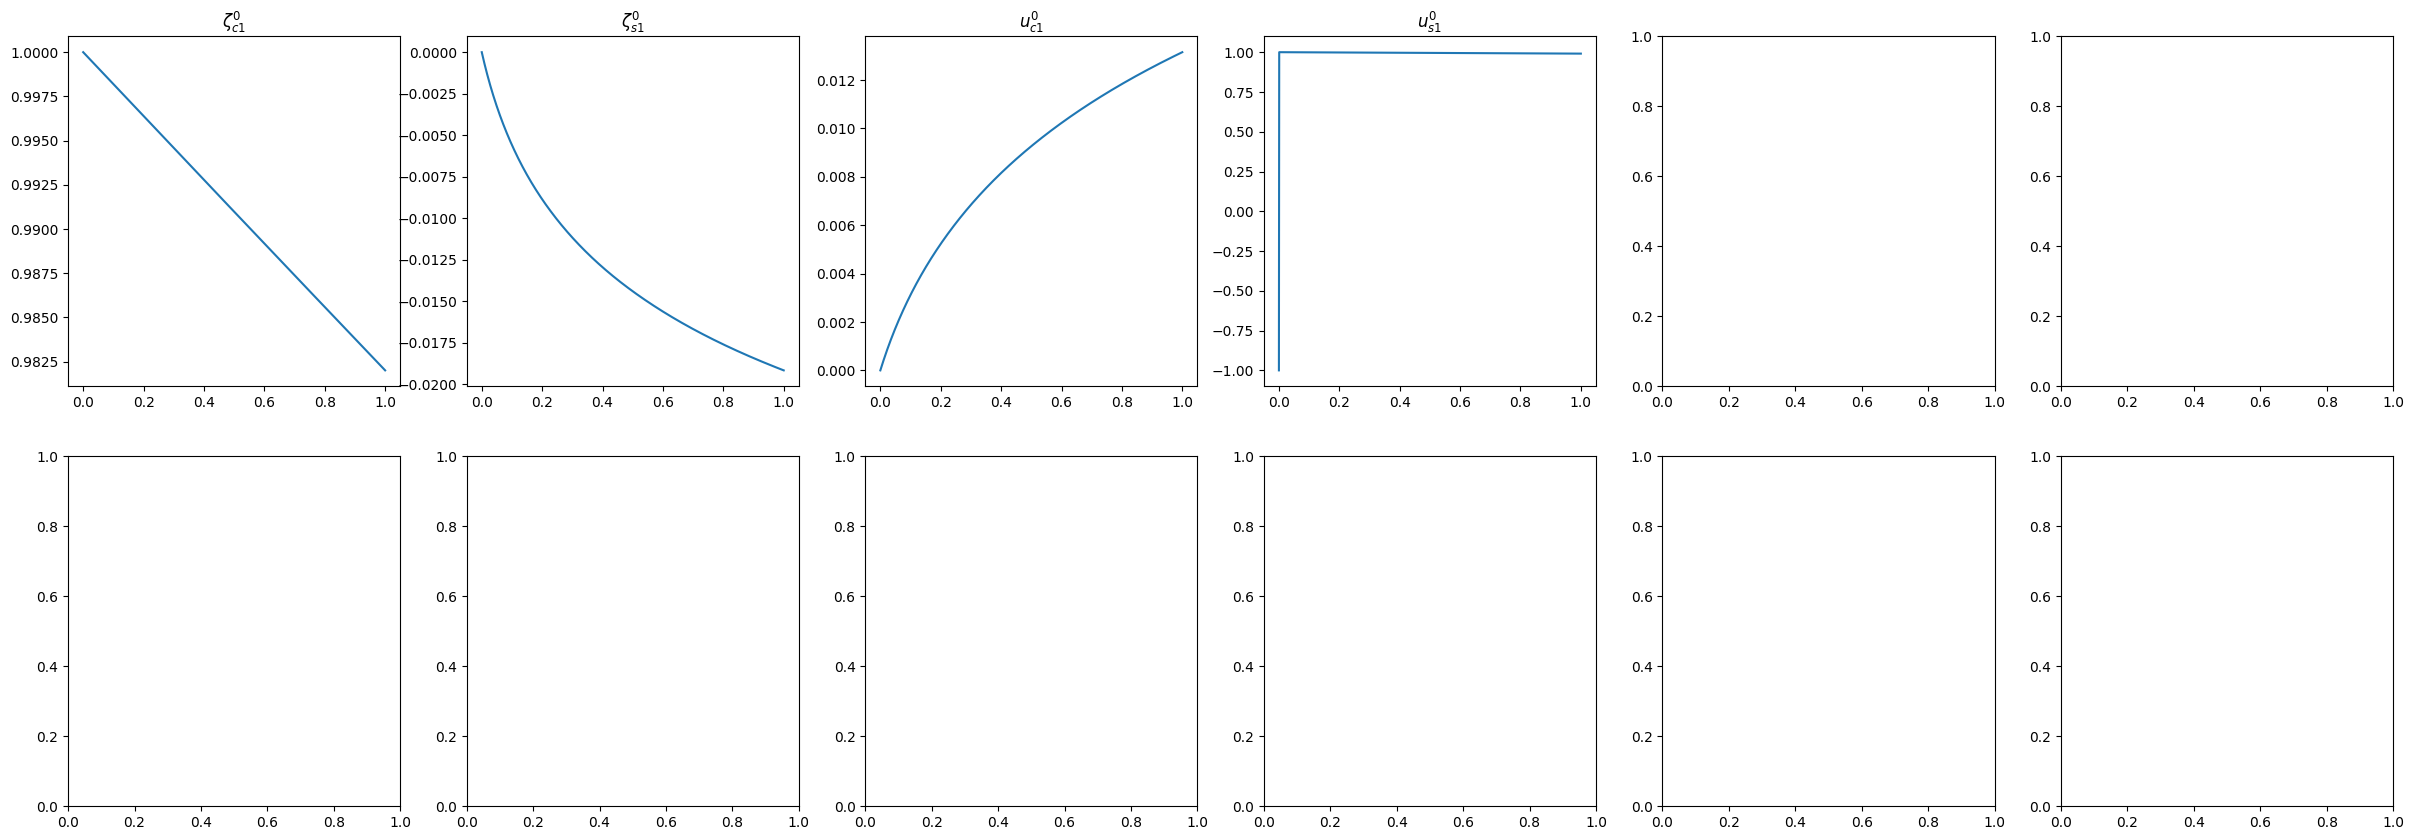

In [78]:
pcswe = PCSWE()
pcswe.h0 = 0.1
pcswe.r = 0.45
pcswe.small_number = 0
pcswe.tol = 1e-5
pcswe.set_derivative_vars()
sol = pcswe.solve_LO_shooting()
x = linspace(0, 1, 1000)


fig, axs = plt.subplots(2, 6, figsize=(30, 10))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]
for i in range(4):
    axs[0, i].set_title(labels[i])
    axs[0, i].plot(x, sol.sol(x)[i][::-1])
plt.show()
